In [2]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import uniform
from qadence import *
from torch import nn, optim, tensor, zeros_like, ones_like, linspace, manual_seed
from torch.autograd import grad
from torch import tan, rand, sin
from itertools import product
import torch
import seaborn as sns

INFO  2025-01-10 22:22:49 - pyqtorch: PyQTorch logger successfully setup with log level 20


# Part 2 - Partial Differential Equations
## Laplace equations in 2D
$\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} = 0$  
Over the domain (x,y) $\epsilon [0, 1]^2$  
With the 4 boundary conditions:
- u(0, y) = $sin(\pi y)$
- u(x, 0) = 0
- u(1, y) = $e^{-\pi}sin(\pi y)$
- u(x, 1) = 0

## The Analytical Solution
$e^{-\pi x}sin(\pi y)$



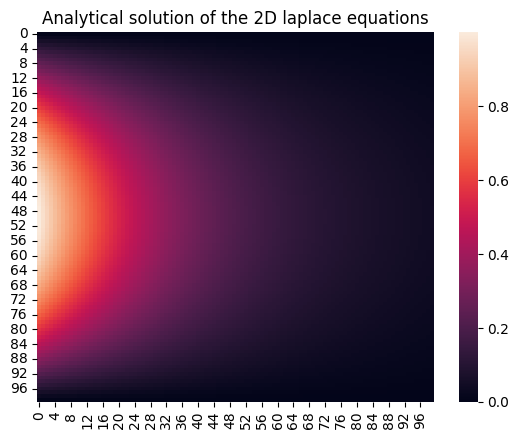

In [11]:
def analytical_sol_laplace(x, y):
    return np.exp(-np.pi * np.array(x)) * np.sin(np.pi * np.array(y))

grid_size = 100
x_points = np.linspace(0, 1, grid_size)
y_points = np.linspace(0, 1, grid_size)
X, Y = np.meshgrid(x_points, y_points)
Z = analytical_sol_laplace(X, Y)

sns.heatmap(Z)
plt.title("Analytical solution of the 2D laplace equations")
plt.show()

## Solving the equations on a DQC

In [20]:
from itertools import product

# randomseed
manual_seed(404)
N_QUBITS, DEPTH, LEARNING_RATE, N_POINTS= 6, 25, 0.01, 200
VARIABLES =("x", "y")
# building the DQC model
ansatz = hea(n_qubits=N_QUBITS, depth=DEPTH)
# the inputdata is encoded viaa feature map
split = N_QUBITS // len(VARIABLES)
fm = kron(
     *[
          feature_map(n_qubits=split, support=support, param=param)
          for param,support in zip(
              VARIABLES,
              [
                  list(list(range(N_QUBITS))[i : i + split])
                  for i in range(N_QUBITS)
                  if i % split == 0
              ],
          )
      ]
)
# choosing acost function
obs = ising_hamiltonian(n_qubits=N_QUBITS)

# building the circuit and the quantum model
circuit = QuantumCircuit(N_QUBITS, chain(fm,ansatz))
model = QNN(circuit=circuit, observable=obs, inputs=VARIABLES)

# using Adamas an optimizer ofchoice
opt = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# define aproblem-specific MSE lossfunction
# for theODE df/dx=4x^3+x^2-2x-1/2
def loss_fn(inputs, outputs):
    dfdxy = grad(inputs=inputs, outputs=outputs, grad_outputs=ones_like(outputs), create_graph=True, retain_graph=True)[0]
    d2fdxy2 = grad(inputs=inputs, outputs=dfdxy, grad_outputs=ones_like(dfdxy), create_graph=True, retain_graph=True)[0]

    ode_loss = d2fdxy2[:, 0] + d2fdxy2[:, 1]

    boundary_loss_1 = model(torch.cat((zeros_like(inputs[:, 0:1]), inputs[:, 1:2]), dim = 1)) - torch.sin(torch.pi * inputs[:, 1:2])
    boundary_loss_2 = model(torch.cat((inputs[:, 0:1], zeros_like(inputs[:, 1:2])), dim = 1))
    boundary_loss_3 = model(torch.cat((ones_like(inputs[:, 0:1]), inputs[:, 1:2]), dim = 1)) - ((torch.e)**(-torch.pi))*torch.sin(torch.pi * inputs[:, 1:2])
    boundary_loss_4 = model(torch.cat((inputs[:, 0:1], ones_like(inputs[:, 1:2])), dim = 1))

    return ode_loss.pow(2).mean() + boundary_loss_1.pow(2).mean() + boundary_loss_2.pow(2).mean() + boundary_loss_3.pow(2).mean() + boundary_loss_4.pow(2).mean()

# collocationpoints sampling and training
for epoch in range(1000):
    opt.zero_grad()
    # the collocation points are sampledrandomly
    cp = rand(size=(N_POINTS, len(VARIABLES)), requires_grad = True)

    loss = loss_fn(inputs = cp , outputs = model(cp))
    loss.backward()
    opt.step()

    print(f"Epoch: {epoch} Loss: {loss.item()}")

# Saving the model
MODEL_SAVE_PATH = "dqc_model.pth"

def save_model(model, optimizer, path):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, path)
    print(f"Model saved to {path}")

save_model(model, opt, MODEL_SAVE_PATH)

Epoch: 0 Loss: 10.638574306259649
Epoch: 1 Loss: 28.337499541131113
Epoch: 2 Loss: 4.6505632922568125
Epoch: 3 Loss: 2.3626296245357756
Epoch: 4 Loss: 9.123885147507787
Epoch: 5 Loss: 7.426940008095968
Epoch: 6 Loss: 3.602718544555328
Epoch: 7 Loss: 2.944035532977036
Epoch: 8 Loss: 5.060113735485401
Epoch: 9 Loss: 4.929605966769671
Epoch: 10 Loss: 2.8897259327296343
Epoch: 11 Loss: 1.6739896466841497
Epoch: 12 Loss: 1.5016463410761518
Epoch: 13 Loss: 1.6885129768042642
Epoch: 14 Loss: 1.4883729235146965
Epoch: 15 Loss: 1.7703087772195243
Epoch: 16 Loss: 1.5675078965910196
Epoch: 17 Loss: 1.5183861771428102
Epoch: 18 Loss: 1.1993764827726363
Epoch: 19 Loss: 0.8346539645519723
Epoch: 20 Loss: 0.9058563125773201
Epoch: 21 Loss: 1.1900197666530867
Epoch: 22 Loss: 1.3154401209100641
Epoch: 23 Loss: 1.1062109268658744
Epoch: 24 Loss: 0.6286703371164247
Epoch: 25 Loss: 0.42434374674766373
Epoch: 26 Loss: 0.5151584990218142
Epoch: 27 Loss: 0.7021972069600725
Epoch: 28 Loss: 0.7314276387551214


In [23]:
# Load function
N_QUBITS, DEPTH, LEARNING_RATE, N_POINTS= 6, 25, 0.01, 200
VARIABLES =("x", "y")
# building the DQC model
ansatz = hea(n_qubits=N_QUBITS, depth=DEPTH)
# the inputdata is encoded viaa feature map
split = N_QUBITS // len(VARIABLES)
fm = kron(
     *[
          feature_map(n_qubits=split, support=support, param=param)
          for param,support in zip(
              VARIABLES,
              [
                  list(list(range(N_QUBITS))[i : i + split])
                  for i in range(N_QUBITS)
                  if i % split == 0
              ],
          )
      ]
)
# choosing acost function
obs = ising_hamiltonian(n_qubits=N_QUBITS)

# building the circuit and the quantum model
circuit = QuantumCircuit(N_QUBITS, chain(fm,ansatz))
model = QNN(circuit=circuit, observable=obs, inputs=VARIABLES)
opt = optim.Adam(model.parameters(), lr=LEARNING_RATE)

def load_model(model, optimizer, path):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print(f"Model loaded from {path}")

# Example of loading the model
load_model(model, opt, "dqc_model.pth")


Model loaded from dqc_model.pth


# Heatmap of the solution

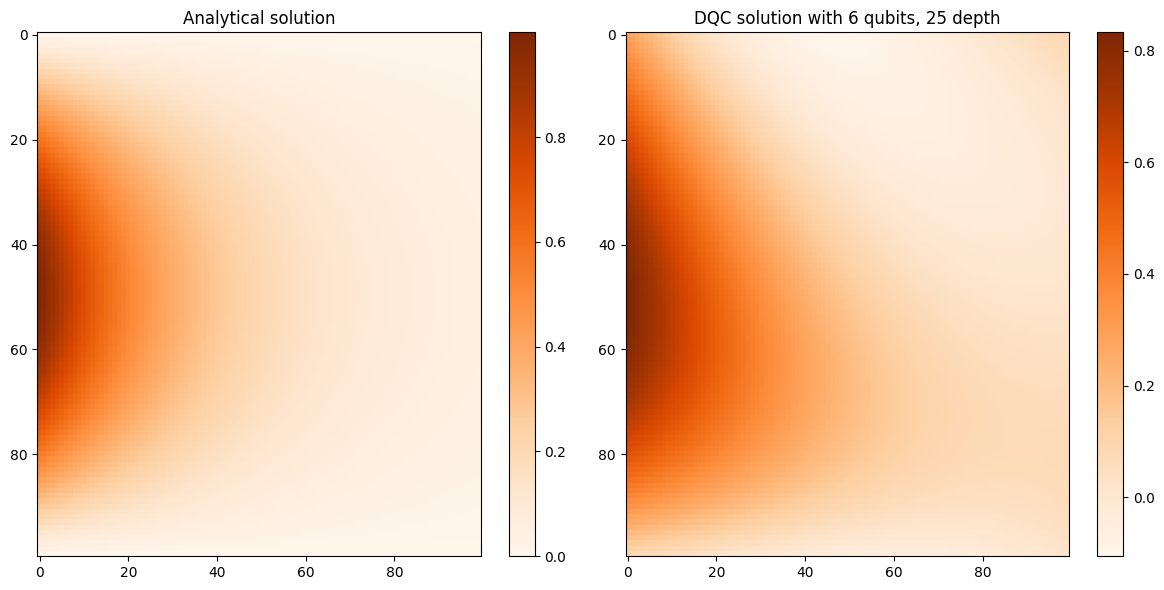

In [36]:
num_points_grid = 100
sample_points_1d =linspace(0, 1.0, steps=num_points_grid).reshape(-1, 1)
model_input = tensor(list(product(sample_points_1d, sample_points_1d))) # note this is Y, X as input and not the other way round 
dqc_sol = model(model_input).reshape(num_points_grid, num_points_grid).detach().numpy().T
meshgrid = np.meshgrid(sample_points_1d, sample_points_1d)
analytical_sol = analytical_sol_laplace(meshgrid[0], meshgrid[1])

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

heatmap1 = ax[0].imshow(analytical_sol, cmap='Oranges', aspect='auto')
ax[0].set_title('Analytical solution')
fig.colorbar(heatmap1, ax=ax[0])

heatmap2 = ax[1].imshow(dqc_sol, cmap='Oranges', aspect='auto')
ax[1].set_title(f"DQC solution with {N_QUBITS} qubits, {DEPTH} depth")
fig.colorbar(heatmap2, ax=ax[1])

# Show plot
plt.tight_layout()
plt.show()